#### The Dataset
###### Packages

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, recall_score, fbeta_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\maria\AppData\Local\Programs\Python\Python312\python.exe


In [3]:
df = pd.read_csv(r"Churn_clean.csv")
df = df.drop('Id_Cliente', axis=1)
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,log_Imp_Bonifici_vs_Competitors,log_Imp_Bonifici_vs_No_Competitors,log_Imp_Gestito_attuale,log_Num_Punti_Programma_Loyalty
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,2853.2,2853.22,0,0,0,0,NaN,2.909984,3.473983,NaN
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,NaN,22053.82,0,0,0,0,3.796631,2.918093,NaN,2.511883
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,NaN,216304.33,1,0,0,0,3.636488,3.032081,NaN,2.662758
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,NaN,NaN,0,0,0,0,NaN,NaN,4.176483,NaN
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,NaN,21514.60,0,0,0,0,NaN,3.079181,NaN,3.562293


In [4]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Convert in 0 and 1
XX = pd.get_dummies(X)


In [5]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train = pd.get_dummies(X)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train.align(X_test, join='inner', axis=1)


#### The Synthetic dataset

In [7]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

In [8]:
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 283)


#### LightGBM 
###### This alghoritm is the fastest one, so we used this one to evaluate and chose the best metric
##### Hyperparameters Tuning

In [9]:

def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        #y_fold_val dovrebbe essere 30190, prendiamo in rapporto circa 1:6
        top_indices = np.argsort(probas)[-5000:]  # Get top 10,000 indices
        top_positives = y_fold_val.iloc[top_indices].sum()  # Count of positives in the top 10,000
        total_positives = y_fold_val.sum()  # Total positives in the validation set
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  # Calculate the ratio

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)



[I 2024-04-26 18:24:59,351] A new study created in memory with name: no-name-c3d6e447-301b-4105-aef6-1ca6fd2eefbf
[I 2024-04-26 18:26:00,293] Trial 0 finished with value: 0.5593396226415094 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.5593396226415094.
[I 2024-04-26 18:28:04,452] Trial 1 finished with value: 0.6823860062893081 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.6823860062893081.
[I 2024-04-26

KeyboardInterrupt: 

###### 'n_estimators': 270, 'learning_rate': 0.01101265837299383, 'max_depth': 8, 'num_leaves': 35, 'min_child_samples': 46, 'subsample': 0.9576587534894431, 'subsample_freq': 6, 'colsample_bytree': 0.7636004284281295, 'reg_alpha': 0.6189641727169579, 'reg_lambda': 0.34978829279646656, 'max_bin': 300


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)


##### Metric: Rank Probabilities

In [13]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) #Cost-Learning function

best_params = {
    'n_estimators': 270, 
    'learning_rate': 0.01101265837299383, 
    'max_depth': 8, 
    'num_leaves': 35, 
    'min_child_samples': 46, 
    'subsample': 0.9576587534894431, 
    'subsample_freq': 6, 
    'colsample_bytree': 0.7636004284281295, 
    'reg_alpha': 0.6189641727169579, 
    'reg_lambda': 0.34978829279646656, 
    'max_bin': 300,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}


best_lgb_classifier = lgb.LGBMClassifier(**best_params) #build the classifier with the chosen parameters
best_lgb_classifier.fit(X_train, y_train) #train the model
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1] #predictions on the test set, select only the predictions for the positive class
print(lgbm_predictions)

[0.10639162 0.44836709 0.13421456 ... 0.54935762 0.0236276  0.31859578]


In [14]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#Top 10k with the highest probability to stay in 'yes'
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
99296        0      0.965130
55475        1      0.962323
189690       0      0.960659
6844         1      0.948003
58243        1      0.942999
...        ...           ...
119922       0      0.498575
206409       0      0.498545
250063       0      0.498538
267772       0      0.498387
323115       0      0.498383

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 299
Number of 'yes' in the test set 383


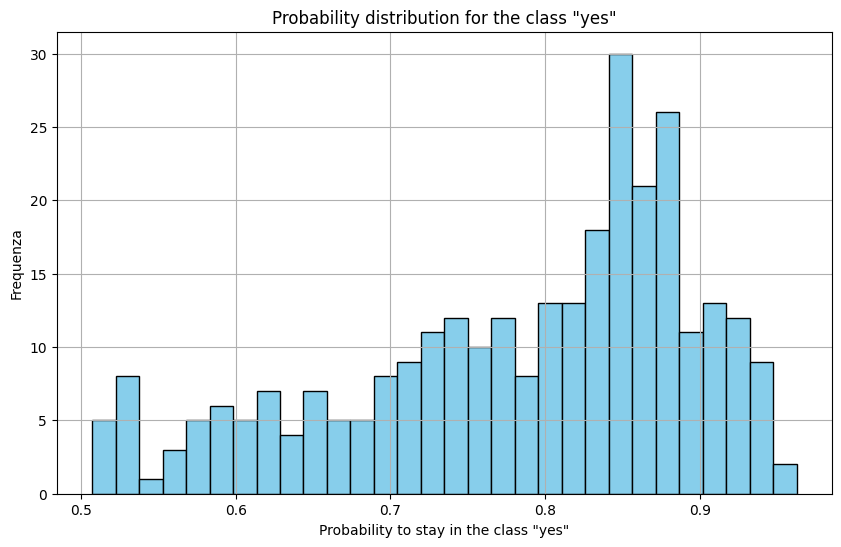

In [16]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

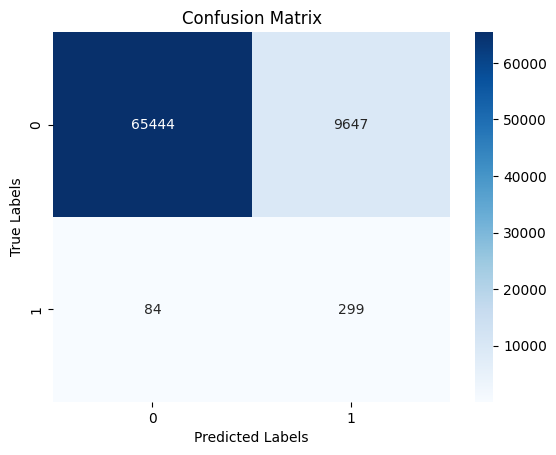

In [17]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Rank probabilities on the synthetic dataset

In [18]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(20000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Number of yes in the 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Number of yes in the test set", count_ones)

       y_test  y_pred_proba
6162        0      0.950819
2430        0      0.915938
6882        0      0.915390
27956       0      0.913349
5485        0      0.908525
...       ...           ...
67190       0      0.215944
30126       0      0.215935
5007        0      0.215911
7034        0      0.215880
66174       0      0.215878

[20000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 295
Numero di 'SI: nel nostro test set 489


#### Metric: Roc Auc

In [33]:
best_params = {
    'n_estimators': 264,
    'learning_rate': 0.011142632664740155,
    'max_depth': 11,
    'num_leaves': 28,
    'min_child_samples': 37,
    'subsample': 0.8024511835587035,
    'subsample_freq': 7,
    'colsample_bytree': 0.883133308624884,
    'reg_alpha': 0.8745173652189913,
    'reg_lambda': 0.9687219187179391,
    'max_bin': 244,
    'force_col_wise': True,
    'verbosity': -1
}
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [34]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17390        1      0.823894
17391        1      0.755370
17570        1      0.706819
62554        1      0.686383
6844         1      0.608239
...        ...           ...
162646       0      0.007114
91482        0      0.007112
158085       0      0.007112
93734        0      0.007111
315244       0      0.007111

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 309
Number of 'yes' in the test set 383


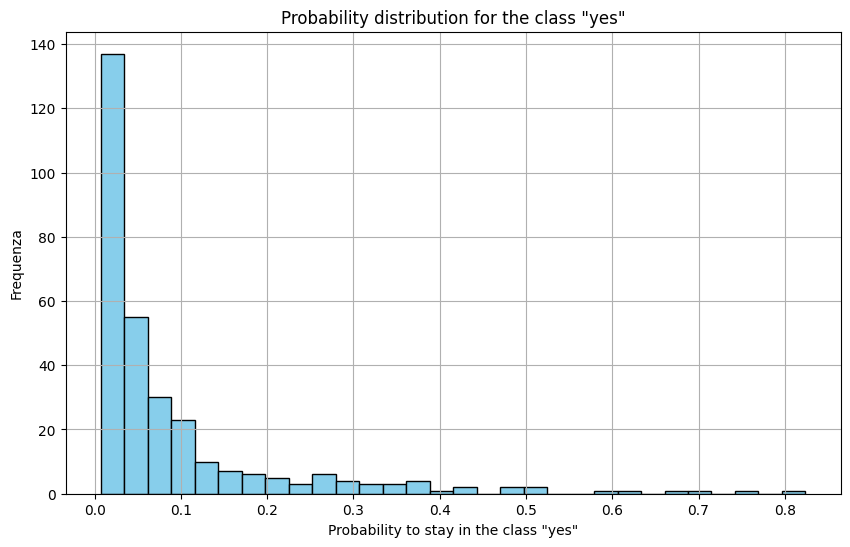

In [35]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

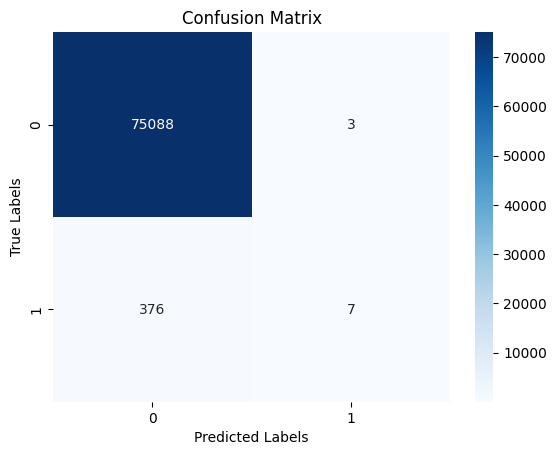

In [36]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Roc Auc on the synthetic dataset

In [37]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(20000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
19193       0      0.330798
23320       0      0.267644
27984       0      0.232285
6882        0      0.222944
6162        0      0.221391
...       ...           ...
67907       0      0.003060
15512       0      0.003060
67920       0      0.003060
6772        0      0.003060
43964       0      0.003060

[20000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 317
Numero di 'SI: nel nostro test set 489


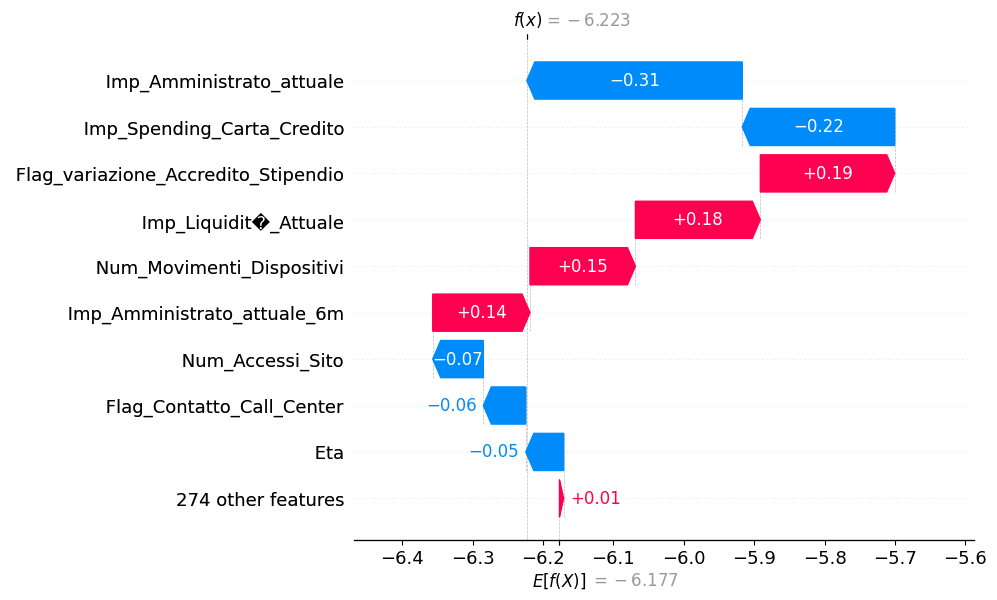

In [38]:
import shap
explainer = shap.TreeExplainer(best_lgb_classifier)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value
# Plot a SHAP Waterfall plot for the first instance in the test set
shap.initjs()  # Necessary for Jupyter Notebooks to display the plot
waterfall_plot = shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[2], X_test.iloc[2])

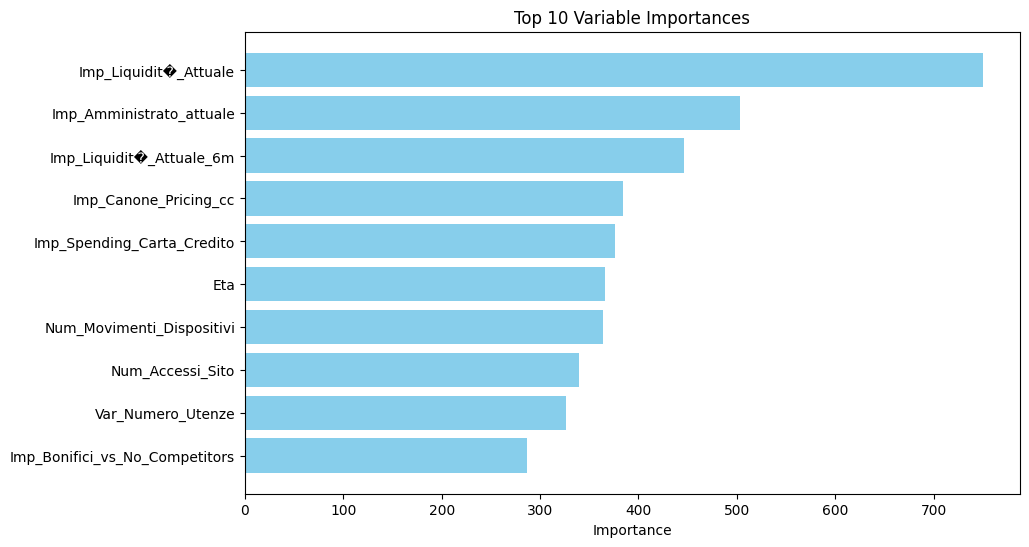

In [26]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric:Recall

In [39]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.02473710933735549,
    'max_depth': 5,
    'num_leaves': 29,
    'min_child_samples': 28,
    'subsample': 0.9979287455244378,
    'subsample_freq': 5,
    'colsample_bytree': 0.9997861136218631,
    'reg_alpha': 0.9741083680472568,
    'reg_lambda': 0.9792814931859342,
    'max_bin': 240,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [40]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
6844         1      0.993772
20382        1      0.991153
54805        1      0.989636
17390        1      0.989087
532          0      0.987945
...        ...           ...
205522       0      0.591803
351509       0      0.591789
51988        0      0.591789
14131        0      0.591651
337410       0      0.591582

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 300
Number of 'yes' in the test set 383


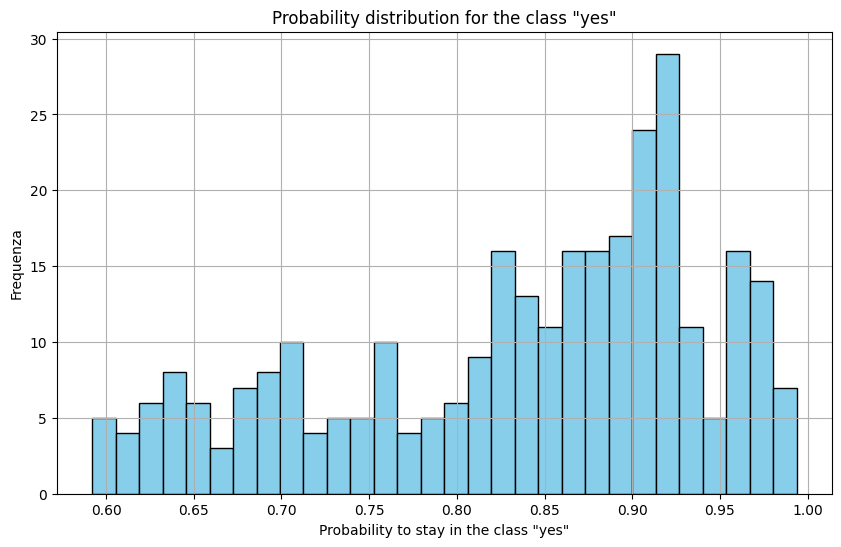

In [41]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

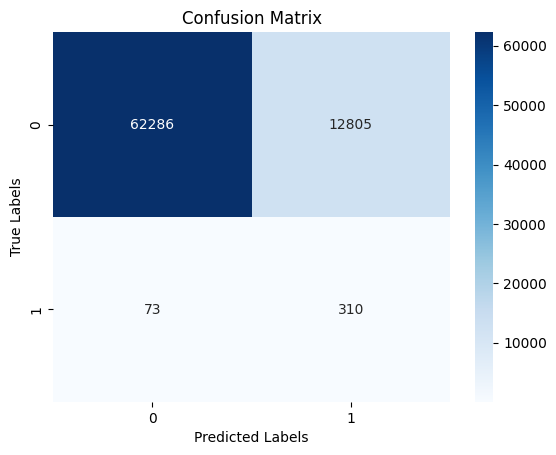

In [42]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Recall on the synthetic dataset

In [43]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
20799       0      0.974077
1285        0      0.970590
63790       0      0.960135
54249       0      0.956468
46400       0      0.954050
...       ...           ...
58463       0      0.485850
43100       0      0.485850
58589       0      0.485793
1153        0      0.485710
42434       0      0.485676

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 203
Numero di 'SI: nel nostro test set 489


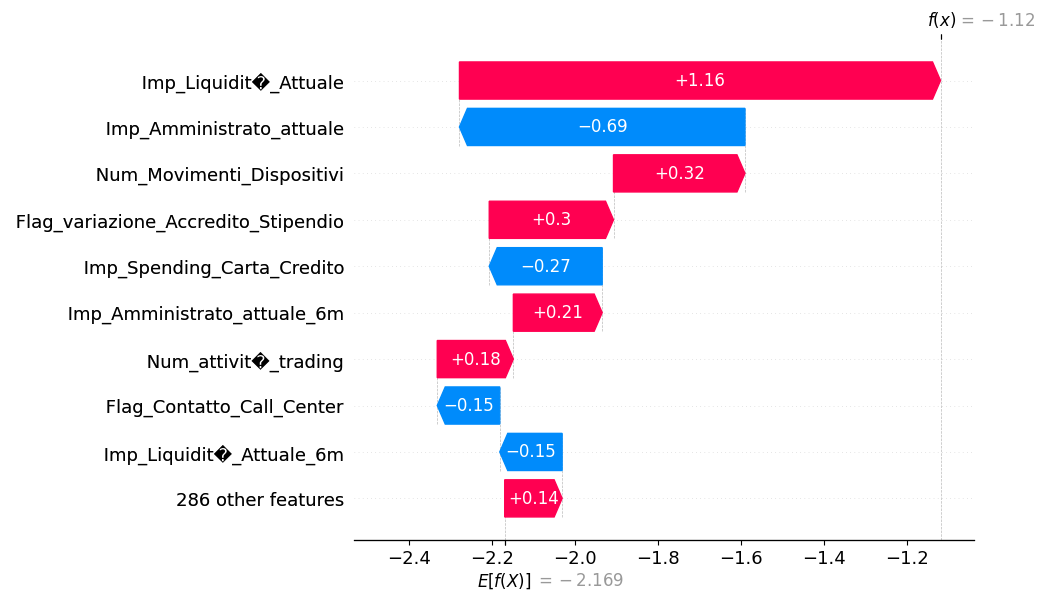

In [64]:
import shap
explainer = shap.TreeExplainer(best_lgb_classifier)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value
# Plot a SHAP Waterfall plot for the first instance in the test set
shap.initjs()  # Necessary for Jupyter Notebooks to display the plot
waterfall_plot = shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[2], X_test.iloc[2])

In [68]:
y_test

231470    0
212880    0
229951    0
95073     0
162445    0
         ..
238075    0
291754    0
336451    0
300241    0
165157    0
Name: Flag_Richiesta_Estinzione_cc, Length: 75474, dtype: int64

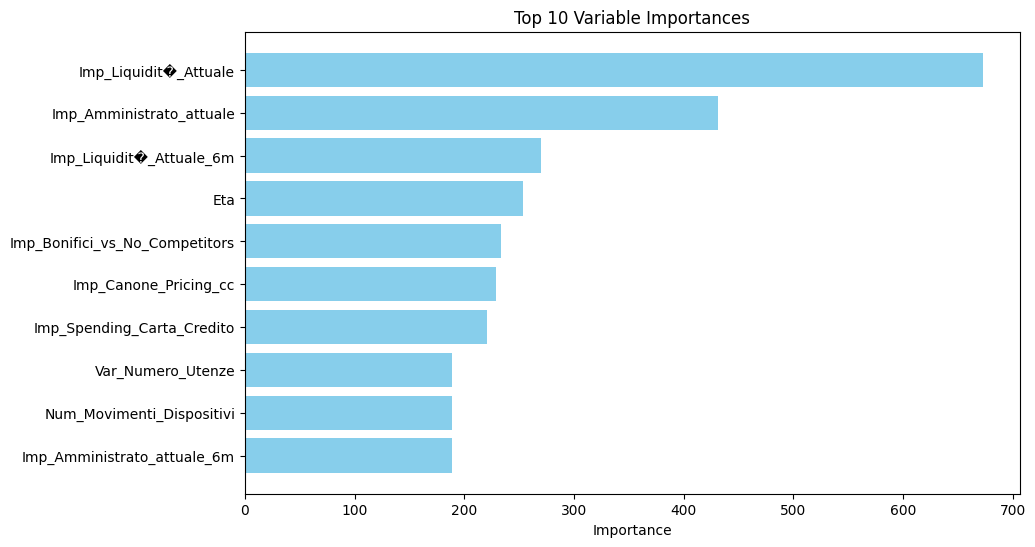

In [32]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric: Precision

In [44]:
best_params = {
    'n_estimators': 222,
    'learning_rate': 0.0035234408126281255,
    'max_depth': 15,
    'num_leaves': 36,
    'min_child_samples': 50,
    'subsample': 0.8024949185836124,
    'subsample_freq': 1,
    'colsample_bytree': 0.694085486904971,
    'reg_alpha': 0.002310729712339969,
    'reg_lambda': 0.8359805786791278,
    'max_bin': 231,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}


best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [45]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
99296        0      0.581319
368493       0      0.579133
17390        1      0.578277
62554        1      0.576703
269653       0      0.576668
...        ...           ...
61313        0      0.299136
165232       0      0.299114
228242       0      0.299109
11318        0      0.299097
162505       0      0.299081

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 295
Number of 'yes' in the test set 383


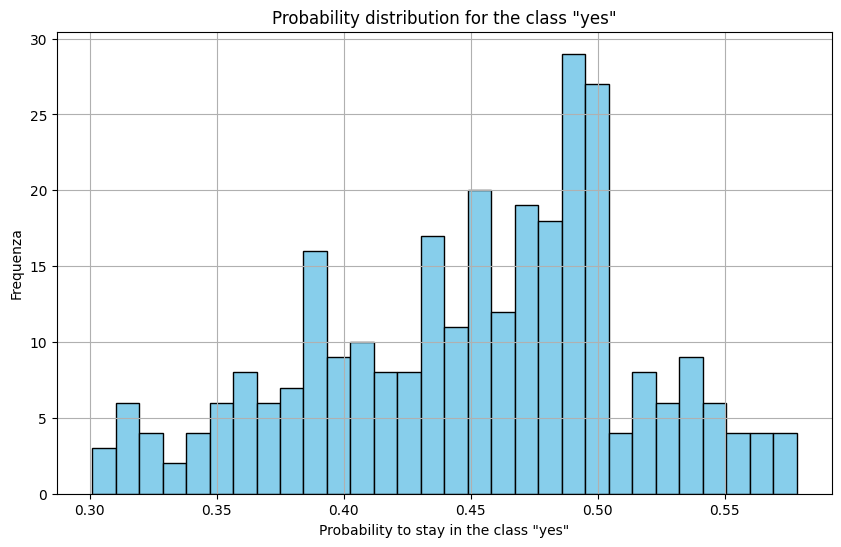

In [46]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

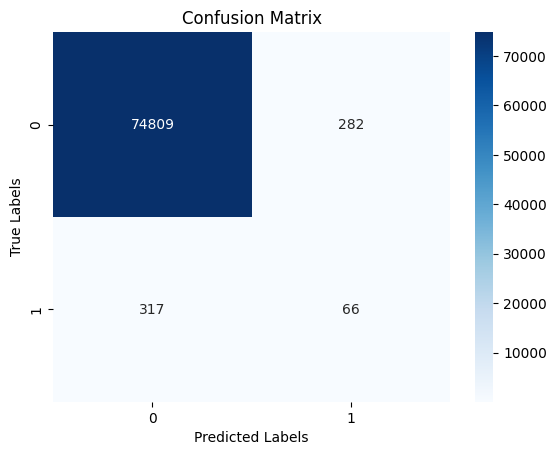

In [47]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Precision on the synthetic dataset

In [48]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
6162        0      0.554078
5485        0      0.553115
6882        0      0.551127
23320       0      0.540326
41587       0      0.529342
...       ...           ...
33762       0      0.229978
54975       0      0.229973
44863       0      0.229973
45651       0      0.229953
368         0      0.229938

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 213
Numero di 'SI: nel nostro test set 489


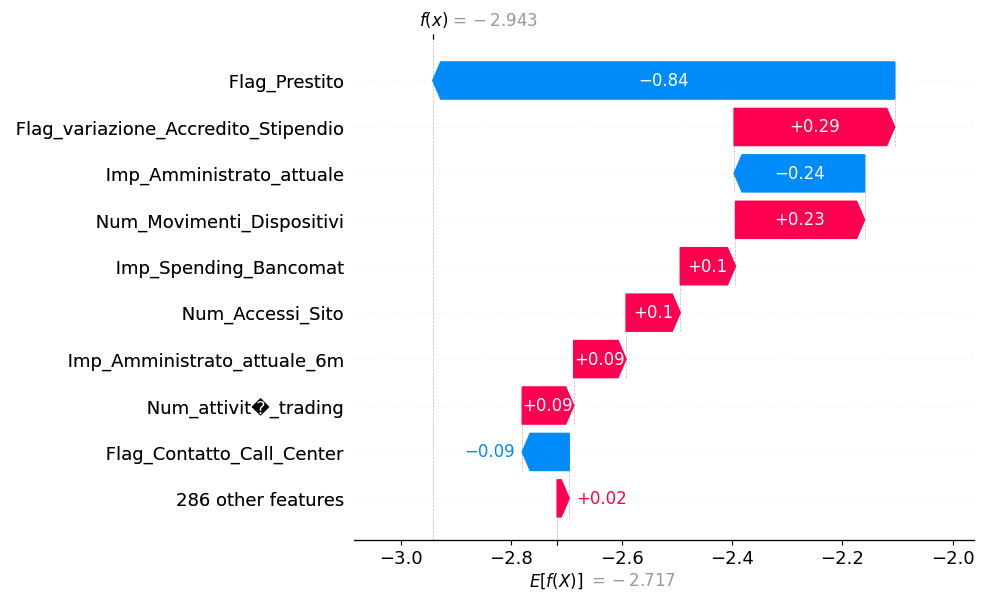

In [39]:
import shap
explainer = shap.TreeExplainer(best_lgb_classifier)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value
# Plot a SHAP Waterfall plot for the first instance in the test set
shap.initjs()  # Necessary for Jupyter Notebooks to display the plot
waterfall_plot = shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[0], X_test.iloc[0])

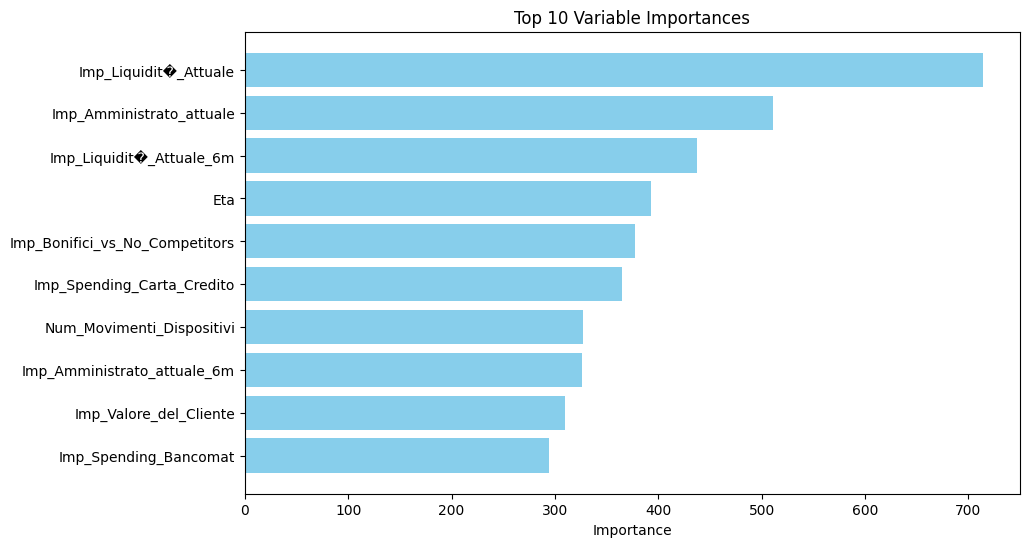

In [40]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric:F1 score

In [52]:
best_params = {
    'n_estimators': 114,
    'learning_rate': 0.006680983417211186,
    'max_depth': 6,
    'num_leaves': 38,
    'min_child_samples': 35,
    'subsample': 0.8661796049705299,
    'subsample_freq': 0,
    'colsample_bytree': 0.7243929286862649,
    'reg_alpha': 0.32518332202674705,
    'reg_lambda': 0.7296061783380641,
    'max_bin': 264,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight, 
    'verbosity': -1
}
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [53]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
281498       0      0.622706
269653       0      0.607838
99296        0      0.602686
55475        1      0.601857
189690       0      0.599777
...        ...           ...
120640       0      0.296270
299917       0      0.296269
91187        0      0.296250
61706        0      0.296249
45836        0      0.296229

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 279
Number of 'yes' in the test set 383


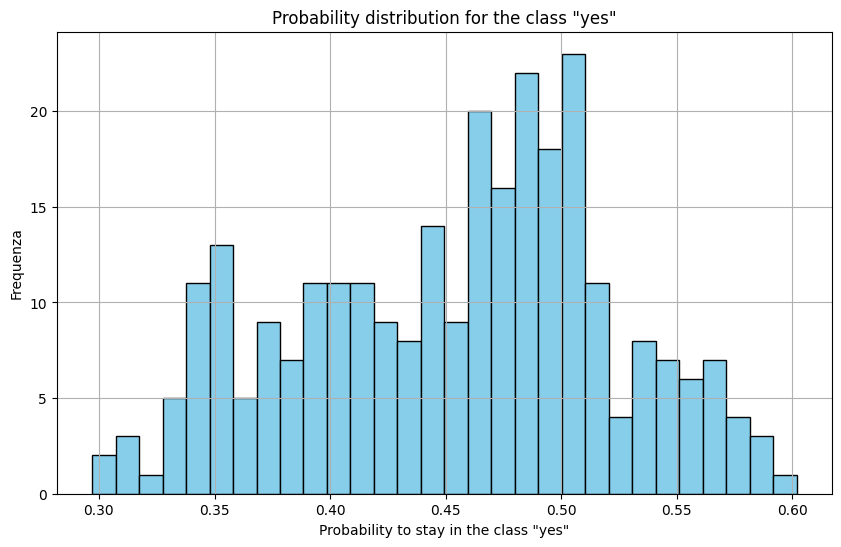

In [55]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

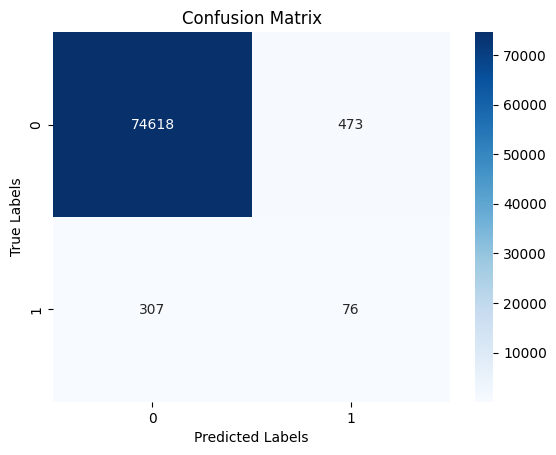

In [56]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

F1 on the synthetic dataset

In [57]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
5485        0      0.585801
22034       0      0.570939
6882        0      0.564266
23320       0      0.556200
58025       0      0.551738
...       ...           ...
47455       0      0.250166
58785       0      0.250164
45138       0      0.250162
45022       0      0.250158
69150       0      0.250150

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 199
Numero di 'SI: nel nostro test set 489


#### Metric:F2 beta

In [58]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.0038506136777269,
    'max_depth': 15,
    'num_leaves': 31,
    'min_child_samples': 49,
    'subsample': 0.9616132068894329,
    'subsample_freq': 6,
    'colsample_bytree': 0.6113887387854107,
    'reg_alpha': 0.0200533381277905,
    'reg_lambda': 0.4152066163632999,
    'max_bin': 233,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [59]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
58243        1      0.608675
6844         1      0.606327
99296        0      0.605021
372830       0      0.602166
55475        1      0.601177
...        ...           ...
359658       0      0.330341
119908       0      0.330317
35902        0      0.330296
66633        0      0.330291
87124        0      0.330291

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 299
Number of 'yes' in the test set 383


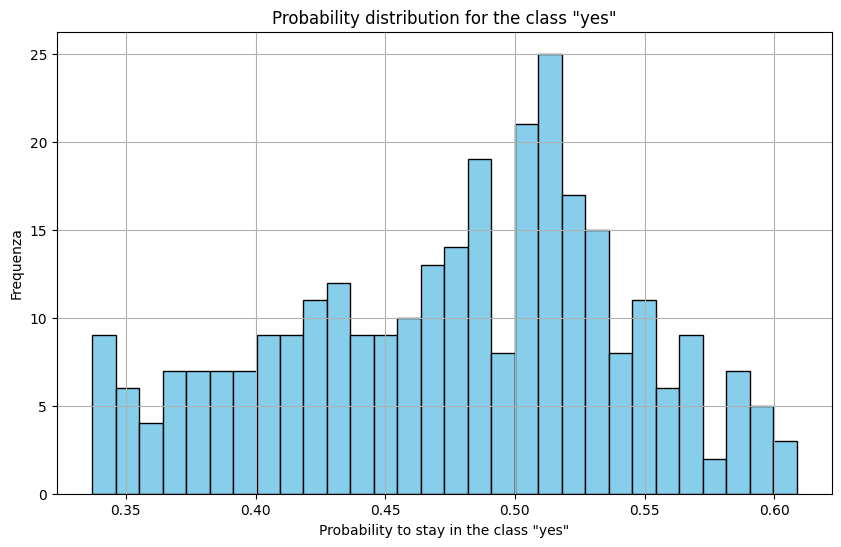

In [61]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

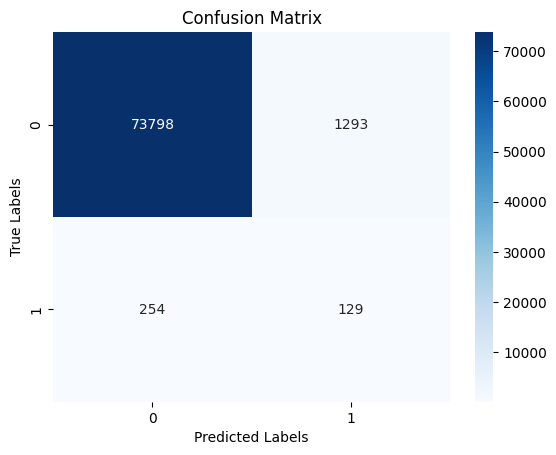

In [62]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


F2 on the synthetic dataset

In [52]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
5569        0      0.576407
6882        0      0.576123
6162        0      0.574910
19193       0      0.569826
33720       0      0.569376
...       ...           ...
27777       0      0.285791
67743       0      0.285773
48411       0      0.285772
26210       0      0.285767
42230       0      0.285765

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 213
Numero di 'SI: nel nostro test set 489


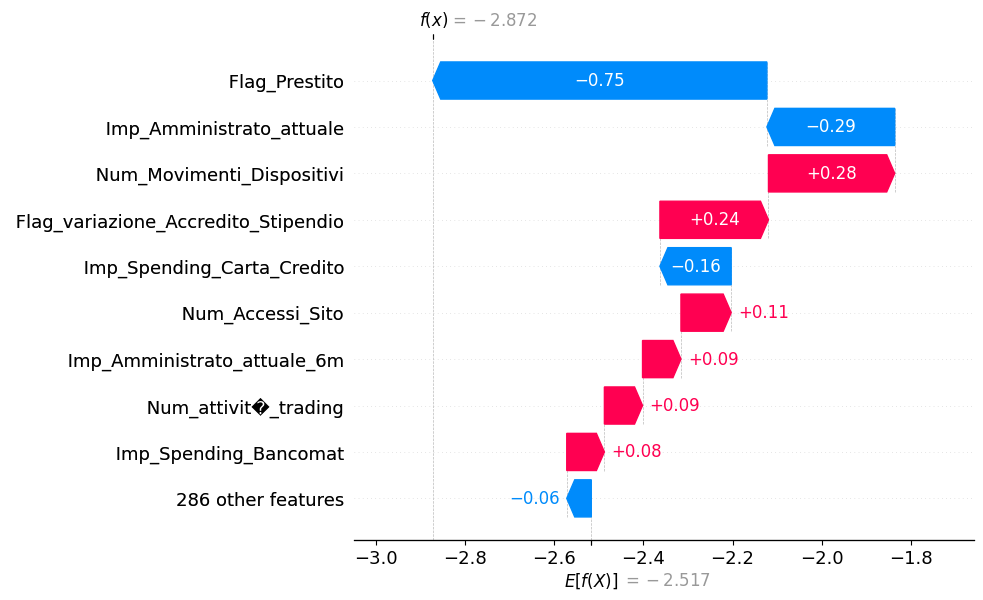

In [53]:
import shap
explainer = shap.TreeExplainer(best_lgb_classifier)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value
# Plot a SHAP Waterfall plot for the first instance in the test set
shap.initjs()  # Necessary for Jupyter Notebooks to display the plot
waterfall_plot = shap.plots._waterfall.waterfall_legacy(expected_value,shap_values[0], X_test.iloc[0])

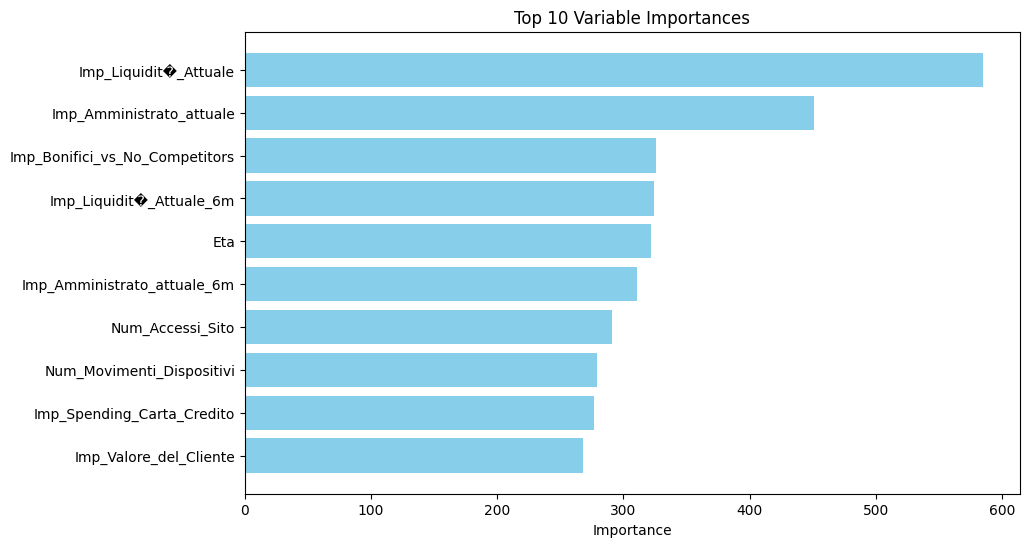

In [54]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
